# **Analysis of big data job requirements based on K-means text clustering in China**


## **Introduction**

As part of this assignment, you will conduct an analysis of job requirements related to big data in China using K-means text clustering. The dataset required for this analysis can be obtained from [https://doi.org/10.1371/journal.pone.0255419](https://doi.org/10.1371/journal.pone.0255419). For more detailed information about the dataset, please refer to the corresponding article at [https://doi.org/10.1371/journal.pone.0255419](https://doi.org/10.1371/journal.pone.0255419). Prior to applying K-means text clustering, it is necessary to preprocess the data. Additionally, after clustering the data, you will need to visualise the clustered data in order to perform data analysis on the resulting cluster groups.

##**Task**

This notebook consists of two sections that require your input: Data Acquisition and Cluster Data Analysis. In both sections, you will encounter code cells with comments labeled as `# YOUR CODE HERE`, which should be followed by the expected outputs your code cells are supposed to produce. To meet the expected outputs, you should insert your implementations in the designated `# YOUR CODE HERE` sections. Note that if your implementation does not produce the expected output, the corresponding component will be marked as **ZERO**. There are also some questions under text cells for you to answer. You should provide your answers in the same text cell right after the question.

# **Global Constants**

In [1]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/gdrive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "/My Drive"
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/BDC Datasets"
DATASET_URL = "https://ndownloader.figstatic.com/files/29057940"
GDRIVE_DATASET_FILE = GDRIVE_DATA_DIR + "/" + DATASET_URL.split("/")[-1]


RANDOM_SEED = 42 # for reproducibility
MAX_K_CLUSTERS = 10 # max number of clusters

# **Spark + Google Colab Setup**

## **1.** Install PySpark and related dependencies

In [2]:
!pip install -q pyspark
# Alternatively, if you want to install a specific version of pyspark:
#!pip install -q pyspark==3.2.1
!pip install -q -U -q PyDrive # To use files that are stored in Google Drive directly (e.g., without downloading them from an external URL)
!apt install -q openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME

## **2.** Import useful Python packages

In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

## **3.** Create Spark context

In [4]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '10G').set('spark.driver.maxResultSize', '10G')

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

## **4.** Link Colab to our Google Drive

In [5]:
# Point Colaboratory to our Google Drive

from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/gdrive


## **5.** Check everything is ok

In [6]:
spark

In [7]:
sc._conf.getAll()

[('spark.app.id', 'local-1684500354404'),
 ('spark.app.startTime', '1684500352409'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.host', '35ed86b3a31d'),
 ('spark.driver.memory', '10G'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.securit

# **Data Acquisition**

In [8]:
def get_data(dataset_url, dest, chunk_size=1024):
  response = requests.get(dataset_url, stream=True)
  if response.status_code == 200:
    with open(dest, "wb") as file:
      for block in response.iter_content(chunk_size=chunk_size): 
        if block: 
          file.write(block)

In [9]:
print("Retrieving dataset from URL: {} ...".format(DATASET_URL))
get_data(DATASET_URL, GDRIVE_DATASET_FILE)
print("Dataset successfully retrieved and stored at: {}".format(GDRIVE_DATASET_FILE))

Retrieving dataset from URL: https://ndownloader.figstatic.com/files/29057940 ...
Dataset successfully retrieved and stored at: /content/gdrive/My Drive/BDC Datasets/29057940


### Read dataset file into a Spark Dataframe




In [10]:
advert_df = pd.read_excel(io=GDRIVE_DATASET_FILE, engine='openpyxl')
advert_df = spark.createDataFrame(advert_df)
advert_df.cache();


### Check the shape of the loaded dataset, i.e., the numbers of rows and columns [1 Mark] 

In [11]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(advert_df.count(), len(advert_df.columns)))

The shape of the dataset is 16551 rows by 7 columns


### Print out the schema of the loaded dataset [1 Mark]

In [12]:
advert_df.printSchema()

root
 |-- Job title: string (nullable = true)
 |-- Salary range: string (nullable = true)
 |-- Location 1: string (nullable = true)
 |-- Location 2: string (nullable = true)
 |-- Experience requirement: string (nullable = true)
 |-- Education requirements: string (nullable = true)
 |-- Job requirements: string (nullable = true)



### Display the first 10 rows of the dataset [1 Mark]

In [13]:
advert_df.show(10)

+--------------------+--------------------+----------+--------------------+----------------------+----------------------+----------------+
|           Job title|        Salary range|Location 1|          Location 2|Experience requirement|Education requirements|Job requirements|
+--------------------+--------------------+----------+--------------------+----------------------+----------------------+----------------+
|Internet data sal...|    15,000 to 20,000|   Beijing|             Beiyuan|             3-5 years|        Junior college|       Full time|
|Internet data sal...|    15,000 to 20,000|   Beijing|             Beiyuan|             3-5 years|        Junior college|       Full time|
|Research and Deve...|    15,000 to 20,000|   Beijing|western informal ...|             3-5 years|                master|       Full time|
|Procurement data ...|7 thousand-12 tho...|   Beijing|  Gaobeidian village|             1-3 years|        Junior college|       Full time|
|Product Manager (...|15 th

### Count the number of records with any missing value (i.e., `NULL`, `NAN`, etc. ) along all columns [2 Marks]

In [14]:
advert_df.select([count(when(isnan(c), c)).alias(c) for c in advert_df.columns]).show()

+---------+------------+----------+----------+----------------------+----------------------+----------------+
|Job title|Salary range|Location 1|Location 2|Experience requirement|Education requirements|Job requirements|
+---------+------------+----------+----------+----------------------+----------------------+----------------+
|        0|           0|         0|      1073|                     0|                     0|               0|
+---------+------------+----------+----------+----------------------+----------------------+----------------+



### Show the corresponding 10 `NULL` and `NAN` entry/ies [1 Mark]

In [15]:
#Since we know that location 2 is the only NULL and NAN column 
advert_df.where(isnan(col("Location 2"))).show(10)

+--------------------+--------------------+----------+----------+----------------------+----------------------+--------------------+
|           Job title|        Salary range|Location 1|Location 2|Experience requirement|Education requirements|    Job requirements|
+--------------------+--------------------+----------+----------+----------------------+----------------------+--------------------+
|     camera operator|4 thousand -6 tho...|   Xi ' an|       NaN|             Ring Road|             1-3 years|      Junior college|
|    Data entry clerk|     2.8 -4 thousand|   Xi ' an|       NaN|           Zhangjiabao|             1-3 years|Technical seconda...|
|Quality control s...|4 thousand -7 tho...|   Xi ' an|       NaN|           Xishao gate|  Experience is unl...|      Junior college|
|Data Processing S...|4 thousand -6 tho...|   Xi ' an|       NaN|                Xiguan|  Experience is unl...|      Junior college|
|Data entry specia...|6 thousand -8 tho...|   Xi ' an|       NaN|    

### Remove `NULL` and `NAN` entry/ies  [2 Marks]

In [16]:
advert_df = advert_df.where(~isnan(col("Location 2")))
print("The shape of the dataset is {:d} rows by {:d} columns".format(advert_df.count(), len(advert_df.columns)))

The shape of the dataset is 15478 rows by 7 columns


### Count the number of duplicate job adverts (if any) [2 Marks]


In [17]:
print("The total number of duplicated job adverts {:d} out of {:d}".
      format(advert_df.count() - advert_df.dropDuplicates().count(), advert_df.count()))

The total number of duplicated job adverts 1013 out of 15478


### Display all duplicate job adverts  [2 Marks]


In [18]:
grouped_data = advert_df.groupBy('Job title', 'Salary range', 'Location 1','Location 2','Experience requirement','Education requirements','Job requirements').agg(count('*').alias('count'))
duplicates = grouped_data.filter(grouped_data['count'] > 1)
duplicates.sort("count", ascending=False).show(n=1013)

+----------------------+--------------------+--------------------+--------------------+----------------------+----------------------+-------------------+-----+
|             Job title|        Salary range|          Location 1|          Location 2|Experience requirement|Education requirements|   Job requirements|count|
+----------------------+--------------------+--------------------+--------------------+----------------------+----------------------+-------------------+-----+
|  The data entry st...|4 thousand -6 tho...|Xihu District, Ha...|           West lake|  Experience is unl...|           High school|          Full time|    7|
|  Data communicatio...|4 thousand -8 tho...|           Changchun|               Linhe|             1-3 years|        Junior college|          Full time|    6|
|  The data entry st...|4 thousand -6 tho...|Xihu District, Ha...|                Xixi|  Experience is unl...|           High school|          Full time|    5|
|  Financial data an...|6 thousand -8 th

### Remove duplicate job adverts  [2 Marks]

In [19]:
advert_df = advert_df.dropDuplicates(advert_df.columns)
print("The total number of unique job adverts: {:d}".format(advert_df.count()))

The total number of unique job adverts: 14465


### Combine the columns `Location 1` and `Location 2` as `Location`  [1 Mark]

In [20]:
advert_df = advert_df.withColumn("Location", concat(col("Location 1"),lit(" "),col("Location 2")))
advert_df = advert_df.select('Job title','Salary range','Location', 'Experience Requirement', 'Education requirements','Job requirements')
advert_df.show(n=10, truncate=False)

+------------------------------------------------------------------------+-----------------------+-------------------------------------+-----------------------+----------------------+----------------+
|Job title                                                               |Salary range           |Location                             |Experience Requirement |Education requirements|Job requirements|
+------------------------------------------------------------------------+-----------------------+-------------------------------------+-----------------------+----------------------+----------------+
|Data warehouse development engineer                                     |Negotiable             |Beijing Chaoyang road                |3-5 years              |Undergraduate course  |Full time       |
|Data visualization engineer assistant (can practice for 5K)             |6 thousand -8 thousand |Beijing Baishiqiao                   |Experience is unlimited|Junior college        |Full time    

### Normalise the data in `Salary range` [10 Marks]

Normalise the records in `Salary range` column according the following definition. For a salary record in the range of $[A,B]$, compute the average $C = \frac{A+B}{2}$ and use the following mapping for the new value of the record:

* If $0 \leq C < 4000$, then `record_value = '(A)<4K'`
* If $4000 \leq C < 8000$, then `record_value = '(B)[4K,8K)'`
* If $8000 \leq C < 12000$, then `record_value = '(C)[8K,12K)'`
* If $12000 \leq C < 16000$, then `record_value = '(D)[12K,16K)'`
* If $16000 \leq C < 20000$, then `record_value = '(E)[16K,20K)'`
* If $C \geq 20000$, then `record_value = '(F)>20K'`
* Otherwise, `record_value = '(G)Interview'`

You must use Pyspark UDF from `from pyspark.sql.functions import udf` to implement this task.

In [21]:
data = advert_df
data = data.withColumn("Salary range", regexp_replace("Salary range", "to", "-"))
data = data.withColumn("Salary range", lower(data["Salary range"]))

In [22]:
#Changing any possible words to numbers
data = data.withColumn("Salary range", regexp_replace("Salary range", "k", "thousand"))
data = data.withColumn("Salary range", regexp_replace("Salary range", "one", "1"))
data = data.withColumn("Salary range", regexp_replace("Salary range", "two", "2"))
data = data.withColumn("Salary range", regexp_replace("Salary range", "three", "3"))
data = data.withColumn("Salary range", regexp_replace("Salary range", "four", "4"))
data = data.withColumn("Salary range", regexp_replace("Salary range", "five", "5"))
data = data.withColumn("Salary range", regexp_replace("Salary range", "six", "6"))
data = data.withColumn("Salary range", regexp_replace("Salary range", "seven", "7"))
data = data.withColumn("Salary range", regexp_replace("Salary range", "eight", "8"))
data = data.withColumn("Salary range", regexp_replace("Salary range", "nine", "9"))


data = data.withColumn('A', split(data['Salary range'], '-')[0]) \
    .withColumn('B', split(data['Salary range'], '-')[1])


data = data.withColumn("A", regexp_replace("A", " ", ""))

def process_column(df, column):
    df = df.withColumn(column, 
                      when((length(df[column]) == 11) & df[column].rlike("thousand"), concat(df[column], lit("00")))
                      .otherwise(df[column]))
    df = df.withColumn(column, 
                      when((length(df[column]) == 10) & df[column].rlike("thousand"), concat(df[column], lit("000")))
                      .otherwise(df[column]))
    df = df.withColumn(column, 
                      when((length(df[column]) == 9) & df[column].rlike("thousand"), concat(df[column], lit("000")))
                      .otherwise(df[column]))
    df = df.withColumn(column, 
                      when((length(df[column]) == 3), concat(df[column], lit("00")))
                      .otherwise(df[column]))
    df = df.withColumn(column, regexp_replace(column, "thousand", ""))
    df = df.withColumn(column, regexp_replace(col(column), "[^\w\s]", ""))
    
    return df

data = process_column(data, "A")
data = data.withColumn("B", regexp_replace("B", " ", ""))
data = process_column(data, "B")
data = data.withColumn("A", data["A"].cast("integer"))
data = data.withColumn("B", data["B"].cast("integer"))




In [23]:
def map_salary_range(A, B):
    if A is None or B is None:
        return "(G)Interview"
    else:
        C = (A + B) / 2
        if 0 <= C < 4000:
            return "(A) <4K"
        elif 4000 <= C < 8000:
            return "(B)[4K,8K)"
        elif 8000 <= C < 12000:
            return "(C)[8K,12K)"
        elif 12000 <= C < 16000:
            return "(D)[12K,16K)"
        elif 16000 <= C < 20000:
            return "(E)[16K,20K)"
        elif C >= 20000:
            return "(F)>20K"

map_salary_range_udf = udf(map_salary_range, StringType())

data = data.withColumn('Salary range', map_salary_range_udf(data["A"], data["B"]))
data = data.drop("A")
data = data.drop("B")
advert_df = data
advert_df.show(80)


+--------------------+------------+--------------------+----------------------+----------------------+----------------+
|           Job title|Salary range|            Location|Experience Requirement|Education requirements|Job requirements|
+--------------------+------------+--------------------+----------------------+----------------------+----------------+
|Data warehouse de...|(G)Interview|Beijing Chaoyang ...|             3-5 years|  Undergraduate course|       Full time|
|Data visualizatio...|  (B)[4K,8K)|  Beijing Baishiqiao|  Experience is unl...|        Junior college|       Full time|
|Data Management C...|(D)[12K,16K)|  Beijing Drum tower|             3-5 years|        Junior college|       Full time|
|Data return visit...|  (B)[4K,8K)|Wuhou District, C...|          Under 1 year|        Junior college|       Full time|
|      Data assistant|  (B)[4K,8K)|Chengdu high-tech...|             1-3 years|  Undergraduate course|       Full time|
|Data product manager|     (F)>20K|Wuhou

### Normalise the data in `Location` as `Location` and `Tier`  [5 Marks]

Normalise the records in `Location` column according the following definition. If the string value of the record contains any of the cities in the following dictionary, set the `Location` and the corresponding `Tier` for the record accordingly. If the string value does not contain any of the cities in the dictionary, then the corresponding record must be dropped. You need to pay particular attention to the city `Xi'an` in the records during the normalisation process.

```
cities = dict()
cities["First-tier cities"] = ["Beijing", "Shanghai", "Guangzhou", "Shenzhen"]

cities["New first-tier cities"] = ["Chengdu", "Hefei", "Hangzhou", "Nanjing", 
                                    "Shenyang", "Tianjin", "Wuxi", "Wuhan", 
                                    "Xi'an", "Changsha", "Zhengzhou", "Chongqing"]
                                    
cities["Others"] = ["Dalian", "Fuzhou", "Harbin", "Guiyang", "Jinan", "Ningbo", 
                    "Xiamen", "Shijiazhuang", "Changchun"]
```

You must use Pyspark UDF from `from pyspark.sql.functions import udf` to implement this task.

In [24]:
cities = dict()

cities["First-tier cities"] = ["Beijing", "Shanghai", "Guangzhou", "Shenzhen"]

cities["New first-tier cities"] = ["Chengdu", "Hefei", "Hangzhou", "Nanjing", 
                                    "Shenyang", "Tianjin", "Wuxi", "Wuhan", 
                                    "Xi'an", "Changsha", "Zhengzhou", "Chongqing"]

cities["Others"] = ["Dalian", "Fuzhou", "Harbin", "Guiyang", "Jinan", "Ningbo", 
                    "Xiamen", "Shijiazhuang", "Changchun"]

# Define the normalize_location function
def normalize_location(location):
    for tier, city_list in cities.items():
        for city in city_list:
            if city in location:
                return (city, tier)
            
    return (None, None)

data = advert_df 


data = data.withColumn("Location", initcap(data["Location"]))
data = data.withColumn("Location", regexp_replace("Location", "Xi ' An", "Xi'an"))
data = data.withColumn("Location", regexp_replace("Location", "Xi ' an", "Xi'an"))
data = data.withColumn("Location", regexp_replace("Location", "Xi 'an", "Xi'an"))

  

normalize_location_udf = udf(normalize_location, StructType([
    StructField("Location", StringType(), True),
    StructField("Tier", StringType(), True)
]))


normalized_data = data.withColumn("normalized", normalize_location_udf(data["Location"]))


filtered_data = normalized_data.filter(normalized_data["normalized"]["Location"].isNotNull())


result = filtered_data.withColumn("Location", filtered_data["normalized"]["Location"]) \
                      .withColumn("Tier", filtered_data["normalized"]["Tier"]) \
                      .drop("normalized")

advert_df = result.select("Job title","Salary range", "Location", "Tier","Experience requirement","Education requirements", "Job requirements")
advert_df.show(80)


+--------------------+------------+---------+--------------------+----------------------+----------------------+----------------+
|           Job title|Salary range| Location|                Tier|Experience requirement|Education requirements|Job requirements|
+--------------------+------------+---------+--------------------+----------------------+----------------------+----------------+
|Data warehouse de...|(G)Interview|  Beijing|   First-tier cities|             3-5 years|  Undergraduate course|       Full time|
|Data visualizatio...|  (B)[4K,8K)|  Beijing|   First-tier cities|  Experience is unl...|        Junior college|       Full time|
|Data Management C...|(D)[12K,16K)|  Beijing|   First-tier cities|             3-5 years|        Junior college|       Full time|
|Data return visit...|  (B)[4K,8K)|  Chengdu|New first-tier ci...|          Under 1 year|        Junior college|       Full time|
|      Data assistant|  (B)[4K,8K)|  Chengdu|New first-tier ci...|             1-3 years| 

### Check the shape of the dataset after normalisation, i.e., the numbers of rows and columns

In [25]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(advert_df.count(), len(advert_df.columns)))

The shape of the dataset is 14377 rows by 7 columns


### Normalise the data in `Experience requirement`  [5 Marks]

Normalise the records in `Experience` column according the following definition. For an experience requirement in the range of $[A,B]$, compute the average $C = \frac{A+B}{2}$ and use the following mapping for the new value of the record:

* If $C <= 3$, then `record_value = '(A)1-3 years'`
* If $C > 3$, then `record_value = '(B)More than 3 years'`
* Otherwise, `record_value = '(C)Experience unlimited'`

You must use Pyspark UDF from `from pyspark.sql.functions import udf` to implement this task.


In [26]:
def experience_requirement(A, B):
    if A is None or B is None:
        return "(C)Experience unlimited"
    else:
        C = (A + B) / 2
        if C < 0:
            return "(C)Experience unlimited"
        elif C <= 3:
            return "(A)1-3 years"
        elif C > 3:
            return "(B)More than 3 years"
        else:
            return "(C)Experience unlimited"

experience_requirement_udf = udf(experience_requirement, StringType())


In [27]:
data = advert_df
data = data.withColumn("Experience requirement", regexp_replace("Experience requirement", "years", ""))
data = data.withColumn("Experience requirement", regexp_replace("Experience requirement", "Under 1 year", "1-0"))

data = data.withColumn('A', split(data['Experience requirement'], '-')[0].cast(IntegerType())) \
           .withColumn('B', split(data['Experience requirement'], '-')[1].cast(IntegerType()))


data = data.withColumn('Experience requirement', experience_requirement_udf(data["A"], data["B"]))
data = data.drop("A")
data = data.drop("B")
advert_df = data
advert_df.show(80)



+--------------------+------------+---------+--------------------+----------------------+----------------------+----------------+
|           Job title|Salary range| Location|                Tier|Experience requirement|Education requirements|Job requirements|
+--------------------+------------+---------+--------------------+----------------------+----------------------+----------------+
|Data warehouse de...|(G)Interview|  Beijing|   First-tier cities|  (B)More than 3 years|  Undergraduate course|       Full time|
|Data visualizatio...|  (B)[4K,8K)|  Beijing|   First-tier cities|  (C)Experience unl...|        Junior college|       Full time|
|Data Management C...|(D)[12K,16K)|  Beijing|   First-tier cities|  (B)More than 3 years|        Junior college|       Full time|
|Data return visit...|  (B)[4K,8K)|  Chengdu|New first-tier ci...|          (A)1-3 years|        Junior college|       Full time|
|      Data assistant|  (B)[4K,8K)|  Chengdu|New first-tier ci...|          (A)1-3 years| 

### Normalise the data in `Education requirements`  [5 Marks]

Normalise the records in `Education requirements` column according the following dictionary.

```
education = dict()
education["(A)Primary Education"] = ["Junior high school and below"]
education["(B)Secondary Education"] = ["Technical secondary school/technical secondary school", 
                                    "High school","Junior college"]
education["(C)Undergraduate"] = ["Undergraduate course"]
education["(D)Graduate"] = ["master", "Doctor"]
education["(E)Education Unlimited"] = ["Education is not limited"]
```

You must use Pyspark UDF from `from pyspark.sql.functions import udf` to implement this task.

In [28]:
education = dict()
education["(A)Primary Education"] = ["Junior high school and below"]
education["(B)Secondary Education"] = ["Technical secondary school/technical secondary school", 
                                    "High school","Junior college"]
education["(C)Undergraduate"] = ["Undergraduate course"]
education["(D)Graduate"] = ["master", "Doctor"]
education["(E)Education Unlimited"] = ["Education is not limited"]

def normalize_education(edu_level):
    for key, value in education.items():
        if edu_level in value:
            return key
    return "Unknown"


normalize_education_udf = udf(normalize_education, StringType())


data_normalized = data.withColumn("Education requirements", normalize_education_udf(data["Education requirements"]))



advert_df = data_normalized
advert_df.show(80)

+--------------------+------------+---------+--------------------+----------------------+----------------------+----------------+
|           Job title|Salary range| Location|                Tier|Experience requirement|Education requirements|Job requirements|
+--------------------+------------+---------+--------------------+----------------------+----------------------+----------------+
|Data warehouse de...|(G)Interview|  Beijing|   First-tier cities|  (B)More than 3 years|      (C)Undergraduate|       Full time|
|Data visualizatio...|  (B)[4K,8K)|  Beijing|   First-tier cities|  (C)Experience unl...|  (B)Secondary Educ...|       Full time|
|Data Management C...|(D)[12K,16K)|  Beijing|   First-tier cities|  (B)More than 3 years|  (B)Secondary Educ...|       Full time|
|Data return visit...|  (B)[4K,8K)|  Chengdu|New first-tier ci...|          (A)1-3 years|  (B)Secondary Educ...|       Full time|
|      Data assistant|  (B)[4K,8K)|  Chengdu|New first-tier ci...|          (A)1-3 years| 

# **Data Preprocessing**

In this assignment, we are working with text data in the `Job title` column and our ultimate goal is to cluster job adverts into groups of coherent "topics" using one of the clustering algorithms we know (e.g., K-means). This is a specific task of a more general area, which is referred to as _natural language processing_ (NLP).

As **preliminary** steps of any NLP task, at least the following pipeline must be executed first:

- Text cleaning:
 - Case normalization (<code>lower</code>) -> convert all text to lower case;
 - Filter out _leading_ and _trailing_ whitespaces (<code>trim</code>);
 - Filter out punctuation symbols (<code>regexp_replace</code>);
 - Filter out any internal extra whitespace resulting from the step above (<code>regexp_replace</code> + <code>trim</code>).
- Tokenization (<code>Tokenizer</code>): splitting raw text into a list of individual _tokens_ (i.e., words), typically using whitespace as delimiter 
- Stopwords removal (<code>StopWordsRemover</code>): removing so-called _stopwords_, namely words that do not contribute to the deeper meaning of the document like "the", "a", "me", etc.
- Stemming (<code>SnowballStemmer</code>): reducing each word to its root or base. For example "fishing", "fished", "fisher" all reduce to the stem "fish"

In [29]:
def clean_text(df, column_name="Job title"):
    """ 
    This function takes the raw text data and apply a standard NLP preprocessing pipeline consisting of the following steps:
      - Text cleaning
      - Tokenization
      - Stopwords removal
      - Stemming (Snowball stemmer)

    parameter: dataframe
    returns: the input dataframe along with the `Job title (cleaned)` column as the results of the NLP preprocessing pipeline

    """
    from pyspark.sql.functions import udf, col, lower, trim, regexp_replace
    from pyspark.ml.feature import Tokenizer, StopWordsRemover
    from nltk.stem.snowball import SnowballStemmer

    # Text preprocessing pipeline
    print("***** Text Preprocessing Pipeline *****\n")

    # 1. Text cleaning
    print("# 1. Text Cleaning\n")
    # 1.a Case normalization
    print("1.a Case normalization:")
    lower_case_news_df = df.select("Salary range", "Location", "Tier", "Experience requirement", "Education requirements", lower(col(column_name)).alias(column_name))
    lower_case_news_df.show(10)
    # 1.b Trimming
    print("1.b Trimming:")
    trimmed_news_df = lower_case_news_df.select("Salary range", "Location", "Tier", "Experience requirement", "Education requirements", trim(col(column_name)).alias(column_name))
    trimmed_news_df.show(10)
    # 1.c Filter out punctuation symbols
    print("1.c Filter out punctuation:")
    no_punct_news_df = trimmed_news_df.select("Salary range", "Location", "Tier", "Experience requirement", "Education requirements", (regexp_replace(col(column_name), "[^a-zA-Z\\s]", "")).alias(column_name))
    no_punct_news_df.show(10)
    # 1.d Filter out any internal extra whitespace
    print("1.d Filter out extra whitespaces:")
    cleaned_news_df = no_punct_news_df.select("Salary range", "Location", "Tier", "Experience requirement", "Education requirements", trim(regexp_replace(col(column_name), " +", " ")).alias(column_name))
    cleaned_news_df.show(10)

    # 2. Tokenization (split text into tokens)
    print("# 2. Tokenization:")
    tokenizer = Tokenizer(inputCol=column_name, outputCol="tokens")
    tokens_df = tokenizer.transform(cleaned_news_df)
    tokens_df.show(10)

    # 3. Stopwords removal
    print("# 3. Stopwords removal:")
    stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="terms")
    terms_df = stopwords_remover.transform(tokens_df)
    terms_df.show(10)

    # 4. Stemming (Snowball stemmer)
    print("# 4. Stemming:")
    stemmer = SnowballStemmer(language="english")
    stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
    terms_stemmed_df = terms_df.withColumn("terms_stemmed", stemmer_udf("terms"))
    terms_stemmed_df.show(10)
    
    return terms_stemmed_df

In [30]:
clean_advert_df = clean_text(advert_df)
clean_advert_df.cache()

***** Text Preprocessing Pipeline *****

# 1. Text Cleaning

1.a Case normalization:
+------------+--------+--------------------+----------------------+----------------------+--------------------+
|Salary range|Location|                Tier|Experience requirement|Education requirements|           Job title|
+------------+--------+--------------------+----------------------+----------------------+--------------------+
|(G)Interview| Beijing|   First-tier cities|  (B)More than 3 years|      (C)Undergraduate|data warehouse de...|
|  (B)[4K,8K)| Beijing|   First-tier cities|  (C)Experience unl...|  (B)Secondary Educ...|data visualizatio...|
|(D)[12K,16K)| Beijing|   First-tier cities|  (B)More than 3 years|  (B)Secondary Educ...|data management c...|
|  (B)[4K,8K)| Chengdu|New first-tier ci...|          (A)1-3 years|  (B)Secondary Educ...|data return visit...|
|  (B)[4K,8K)| Chengdu|New first-tier ci...|          (A)1-3 years|      (C)Undergraduate|      data assistant|
|     (F)>20K| Chen

DataFrame[Salary range: string, Location: string, Tier: string, Experience requirement: string, Education requirements: string, Job title: string, tokens: array<string>, terms: array<string>, terms_stemmed: array<string>]

# **Feature Engineering**

Machine learning techniques cannot work directly on text data; in fact, words must be first converted into some numerical representation which machine learning algorithms can make use of. This process is often known as _embedding_ or _vectorization_.

In terms of vectorization, it is important to remember that it isn't merely turning a single word into a single number. While words can be transformed into numbers, an entire document can be translated into a vector. Moreover, vectors derived from text data are usually high-dimensional. This is because each dimension of the feature space will correspond to a word, and the language in the documents may have thousands of words.

## TF-IDF
In information retrieval, **tf-idf** - short for term frequency-inverse document frequency - is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

The tf-idf value increases proportionally to the number of times a word appears in the document and is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general.

In [31]:
def extract_tfidf_features(df, column_name="terms_stemmed", vocabSize=1000, minDF=100, numFeatures=200):
    """ 
    This function takes the text data and converts it into a term frequency-inverse document frequency vector

    parameter: dataframe
    returns: dataframe with tf-idf vectors

    """

    # Importing the feature transformation classes for doing TF-IDF 
    from pyspark.ml.feature import HashingTF, CountVectorizer, IDF
    from pyspark.ml import Pipeline

    ## Creating Term Frequency Vector for each word
    #cv = CountVectorizer(inputCol=column_name, outputCol="tf_features", vocabSize=vocabSize, minDF=minDF)
    #cvModel = cv.fit(df)
    #tf_features_df = cvModel.transform(df)

    ## Alternatively to CountVectorizer, use HashingTF
    #hashingTF = HashingTF(inputCol=column_name, outputCol="tf_features", numFeatures=numFeatures)
    #tf_features_df = hashingTF.transform(df)

    ## Carrying out Inverse Document Frequency on the TF data
    #idf = IDF(inputCol="tf_features", outputCol="features")
    #idfModel = idf.fit(tf_features_df)
    #tf_idf_features_df = idfModel.transform(tf_features_df)

    # USING PIPELINE
    cv = CountVectorizer(inputCol=column_name, outputCol="tf_features", vocabSize=vocabSize, minDF=minDF)
    # hashingTF = HashingTF(inputCol=column_name, outputCol="tf_features", numFeatures=numFeatures)
    idf = IDF(inputCol="tf_features", outputCol="features")

    pipeline = Pipeline(stages=[cv, idf]) # replace `cv` with `hashingTF` if needed
    features = pipeline.fit(df)
    tf_idf_features_df = features.transform(df)

    return tf_idf_features_df

In [32]:
tf_idf_df = extract_tfidf_features(clean_advert_df)
tf_idf_df.cache()

DataFrame[Salary range: string, Location: string, Tier: string, Experience requirement: string, Education requirements: string, Job title: string, tokens: array<string>, terms: array<string>, terms_stemmed: array<string>, tf_features: vector, features: vector]

### Clean-up unused variables

In [33]:
# Let's try to free-up some RAM
import gc

del advert_df
del clean_advert_df
# ...

print("Garbage collector: collected %d objects" % (gc.collect()))

Garbage collector: collected 435 objects


In [34]:
tf_idf_df.select(col("features")).show(10, truncate=False)

+----------------------------------------------------------------------------------------------------------------+
|features                                                                                                        |
+----------------------------------------------------------------------------------------------------------------+
|(74,[0,1,3,33],[0.3156582264113388,1.3800543075917189,2.037624076745449,4.1011838658723425])                    |
|(74,[0,1,12,21],[0.3156582264113388,1.3800543075917189,3.308153326806107,3.7896293572140793])                   |
|(74,[0,5,14],[0.3156582264113388,2.267594506859808,3.569567472437278])                                          |
|(74,[0,7],[0.3156582264113388,2.5311683676040735])                                                              |
|(74,[0,12],[0.3156582264113388,3.308153326806107])                                                              |
|(74,[0,5,10],[0.3156582264113388,2.267594506859808,3.233095235816065])         

### Check and remove any possible zero-length vector

In [35]:
@udf("long")
def num_nonzeros(v):
    return v.numNonzeros()

### Check if there is any zero-length vector


In [36]:
print("Total n. of zero-length vectors: {:d}".
      format(tf_idf_df.where(num_nonzeros("features") == 0).count()))

Total n. of zero-length vectors: 330


### Remove zero-length vector(s)

In [37]:
tf_idf_df = tf_idf_df.where(num_nonzeros("features") > 0)

### Double-check there is no more zero-length vector

In [38]:
print("Total n. of zero-length vectors (after removal): {:d}".
      format(tf_idf_df.where(num_nonzeros("features") == 0).count()))

Total n. of zero-length vectors (after removal): 0


In [39]:
print("Garbage collector: collected %d objects" % (gc.collect()))

Garbage collector: collected 97 objects


# **K-means Clustering**

### Function used for running K-means

In [40]:
def k_means(dataset, 
            n_clusters, 
            distance_measure="euclidean", 
            max_iter=20, 
            features_col="features", 
            prediction_col="cluster", 
            random_seed=RANDOM_SEED):
  
  from pyspark.ml.clustering import KMeans
  from pyspark.ml.feature import Normalizer

  print("""Training K-means clustering using the following parameters: 
  - K (n. of clusters) = {:d}
  - max_iter (max n. of iterations) = {:d}
  - distance measure = {:s}
  - random seed = {:d}
  """.format(n_clusters, max_iter, distance_measure, random_seed))

  if distance_measure == "cosine":
      # Normalize inputs to unit-length vectors
      dataset = Normalizer(inputCol=features_col, outputCol=features_col+"_norm", p=1).transform(dataset)
      features_col = features_col+"_norm"
  # Train a K-means model
  kmeans = KMeans(featuresCol=features_col, 
                   predictionCol=prediction_col, 
                   k=n_clusters, 
                   initMode="k-means||", 
                   initSteps=5, 
                   tol=0.000001, 
                   maxIter=max_iter, 
                   seed=random_seed, 
                   distanceMeasure=distance_measure)
  model = kmeans.fit(dataset)

  # Make clusters
  clusters_df = model.transform(dataset)

  return model, clusters_df

### Function used to evaluate obtained clusters

In [41]:
def evaluate_k_means(clusters, 
                     metric_name="silhouette", 
                     distance_measure="squaredEuclidean", # cosine
                     prediction_col="cluster"
                     ):
  
  from pyspark.ml.evaluation import ClusteringEvaluator
  
  # Evaluate clustering by computing Silhouette score
  evaluator = ClusteringEvaluator(metricName=metric_name,
                                  distanceMeasure=distance_measure, 
                                  predictionCol=prediction_col
                                  )

  return evaluator.evaluate(clusters)

### Select the Best Value of K with the Elbow Method

In [42]:
def do_clustering():
    clustering_results = {}
    for k in range(5, MAX_K_CLUSTERS + 1, 5):
        print("Running K-means using K = {:d}".format(k))
        model, clusters_df = k_means(tf_idf_df, k, max_iter=50, distance_measure="cosine") # Alternatively, distance_measure="euclidean"
        silhouette_k = evaluate_k_means(clusters_df, distance_measure="cosine") # Alternatively, distance_measure="squaredEuclidean"
        wssd_k = model.summary.trainingCost
        print("Silhouette coefficient computed with cosine distance: {:.3f}".format(silhouette_k))
        print("Within-cluster Sum of Squared Distances (using cosine distance): {:.3f}".format(wssd_k))
        print("--------------------------------------------------------------------------------------")
        clustering_results[k] = (silhouette_k, wssd_k)
        # Free up memory space at the end of each iteration
        del model
        del clusters_df
        gc.collect()
    return clustering_results

In [43]:
clustering_results = do_clustering()

Running K-means using K = 5
Training K-means clustering using the following parameters: 
  - K (n. of clusters) = 5
  - max_iter (max n. of iterations) = 50
  - distance measure = cosine
  - random seed = 42
  
Silhouette coefficient computed with cosine distance: 0.175
Within-cluster Sum of Squared Distances (using cosine distance): 7724.345
--------------------------------------------------------------------------------------
Running K-means using K = 10
Training K-means clustering using the following parameters: 
  - K (n. of clusters) = 10
  - max_iter (max n. of iterations) = 50
  - distance measure = cosine
  - random seed = 42
  
Silhouette coefficient computed with cosine distance: 0.238
Within-cluster Sum of Squared Distances (using cosine distance): 6469.251
--------------------------------------------------------------------------------------


In [44]:
def plot_clustering_results(clustering_results):
    # load the dictionary into pandas
    df = pd.DataFrame.from_dict(clustering_results, orient='index').reset_index()
    df.columns = ['K','Silhouette', 'WSSD']
    # Create a 1x1 figure
    fig, ax = plt.subplots(1,1, figsize=(8,6))

    _ = sns.pointplot(data=df, x="K", y="WSSD", ax=ax, color="orangered")
    _ = ax.set_xlabel("K")
    _ = ax.set_ylabel("WSSD")

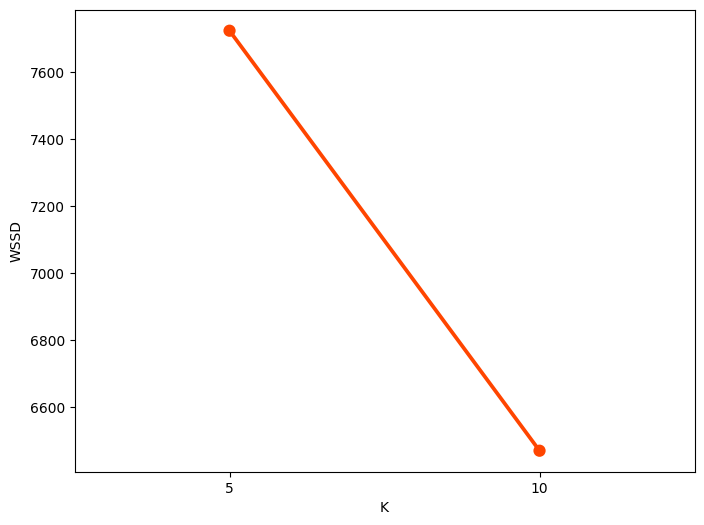

In [45]:
plot_clustering_results(clustering_results)

In [46]:
K=10 # Best value of K (whatever this is!)
print("Running K-means using K = {:d}".format(K))
model, clusters_df = k_means(tf_idf_df, K, max_iter=50, distance_measure="cosine")
clusters_df.cache()

Running K-means using K = 10
Training K-means clustering using the following parameters: 
  - K (n. of clusters) = 10
  - max_iter (max n. of iterations) = 50
  - distance measure = cosine
  - random seed = 42
  


DataFrame[Salary range: string, Location: string, Tier: string, Experience requirement: string, Education requirements: string, Job title: string, tokens: array<string>, terms: array<string>, terms_stemmed: array<string>, tf_features: vector, features: vector, features_norm: vector, cluster: int]

### Inspect some clusters

In [47]:
clusters_df.groupBy("cluster").count().sort("cluster").show()

+-------+-----+
|cluster|count|
+-------+-----+
|      0| 1156|
|      1| 4183|
|      2|  321|
|      3| 1567|
|      4|  614|
|      5| 1096|
|      6| 1379|
|      7|  669|
|      8| 1370|
|      9| 1692|
+-------+-----+



In [48]:
# Get unique values in the grouping column
clusters = sorted([x[0] for x in clusters_df.select("cluster").distinct().collect()])
print("Cluster IDs: [{:s}]".format(", ".join([str(c) for c in clusters])))

# Create a filtered DataFrame for each group in a list comprehension
cluster_list = [clusters_df.where(clusters_df.cluster == x) for x in clusters]

# Show the results
for x_id, x in enumerate(cluster_list):
  print("Showing the first 20 records of cluster ID #{:d}".format(x_id))
  x.select(["cluster", "Job title", "Salary range", "Location", "Tier", "Experience requirement", "Education requirements"]).show(20, truncate=False)

Cluster IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Showing the first 20 records of cluster ID #0
+-------+---------------------------------------------------------------------------------------+------------+---------+---------------------+-----------------------+----------------------+
|cluster|Job title                                                                              |Salary range|Location |Tier                 |Experience requirement |Education requirements|
+-------+---------------------------------------------------------------------------------------+------------+---------+---------------------+-----------------------+----------------------+
|0      |big data statistics assistant wrapdouble break                                         |(B)[4K,8K)  |Shenzhen |First-tier cities    |(C)Experience unlimited|(B)Secondary Education|
|0      |data entry clerk                                                                       |(B)[4K,8K)  |Tianjin  |New first-tier cities|(C)Exper

# **Cluster Data Analysis**

### Show the first 10 most frequently occuring terms in each cluster [5 Marks]

In [49]:
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.functions import split, explode, col, count, desc

# Define a list of stop words
stop_words = ['and', 'of', 'in']

for x_id, x in enumerate(cluster_list):
    Job_title = x.select("Job title")
    print("The shape of the dataset is {:d} rows by {:d} columns".format(Job_title.count(), len(Job_title.columns)))
    Job_title_split = Job_title.select(split(col("Job title"), '\s+').alias('split'))
    remover = StopWordsRemover(inputCol="split", outputCol="filtered", stopWords=stop_words)
    Job_title_filtered = remover.transform(Job_title_split)
    Job_title_exploded = Job_title_filtered.select(explode(col("filtered")).alias('word'))
    Job_title_clean = Job_title_exploded.where(col("word") != '')
    print("Showing the highest 10 frequency terms for Cluster {:d}".format(x_id))
    Job_title_clean.groupBy("word").count().orderBy(desc("count")).show(10)



The shape of the dataset is 1156 rows by 1 columns
Showing the highest 10 frequency terms for Cluster 0
+----------+-----+
|      word|count|
+----------+-----+
|      data|  787|
|     clerk|  423|
|       one|  258|
|     entry|  219|
|     break|  205|
| insurance|  184|
|    double|  182|
|      gold|  181|
|         k|  180|
|statistics|  159|
+----------+-----+
only showing top 10 rows

The shape of the dataset is 4183 rows by 1 columns
Showing the highest 10 frequency terms for Cluster 1
+-----------+-----+
|       word|count|
+-----------+-----+
|       data| 3335|
|   engineer| 2979|
|development| 1618|
|        big| 1608|
|  operation|  367|
|     senior|  274|
|  architect|  202|
|   database|  187|
|  warehouse|  178|
| operations|  140|
+-----------+-----+
only showing top 10 rows

The shape of the dataset is 321 rows by 1 columns
Showing the highest 10 frequency terms for Cluster 2
+-----------+-----+
|       word|count|
+-----------+-----+
|   software|  205|
|   enginee

### Salary range analysis of jobs according to city tier system [5 Marks]

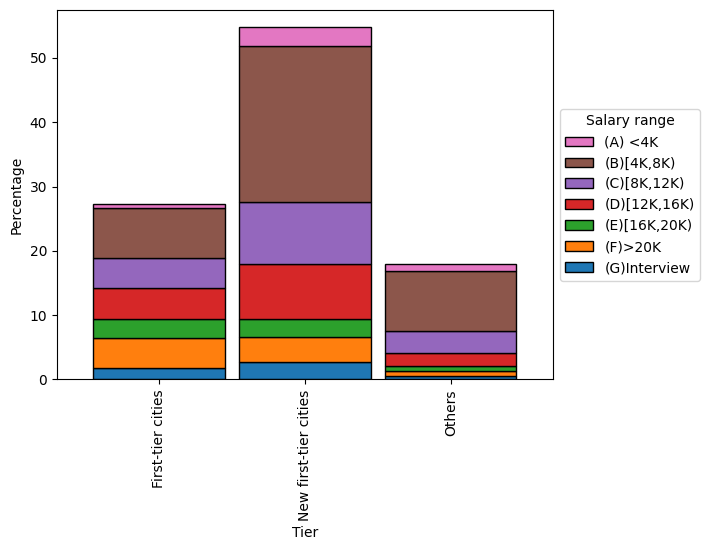

In [50]:
import pandas as pd
import matplotlib.pyplot as plt


dfs = []

for x_id, x in enumerate(cluster_list):
    tier_salary_counts = x.groupBy("Tier", "Salary Range").count()
    tier_salary_counts_pd = tier_salary_counts.toPandas()
    tier_salary_counts_pd['Cluster'] = x_id
    dfs.append(tier_salary_counts_pd)

df = pd.concat(dfs)
df_pivot = df.pivot_table(index='Tier', columns='Salary Range', values='count', aggfunc='sum')
df_pivot = df_pivot.fillna(0) 


df_pivot = df_pivot / df_pivot.sum().sum()
df_pivot = df_pivot * 100
df_pivot = df_pivot[df_pivot.columns[::-1]]

ax = df_pivot.plot(kind='bar', stacked=True, edgecolor='black', width=0.9)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5), title='Salary range')
plt.ylabel('Percentage')
plt.xlabel('Tier')
plt.show()

### Proportions of jobs available in each cluster [5 Marks]

Text(0, 0.5, '')

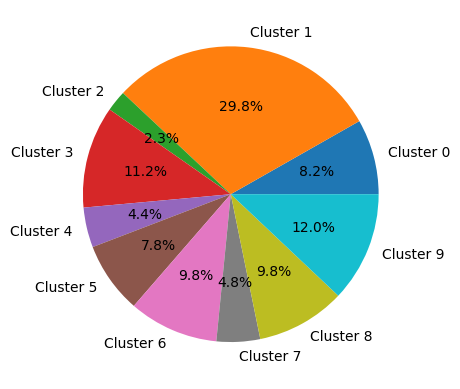

In [51]:

cluster_sizes = [] 

for x_id, x in enumerate(cluster_list):
    Job_title = x.select("Job title")
    cluster_size = x.count()
    cluster_sizes.append(cluster_size) 

cluster_labels = [f'Cluster {i}' for i in range(len(cluster_sizes))]
df = pd.DataFrame({'Cluster Size': cluster_sizes}, index=cluster_labels)

ax = df.plot.pie(y='Cluster Size', autopct='%.1f%%', legend=False)
ax.set_ylabel('')

### Education requirements analysis of jobs in each cluster [5 Marks]


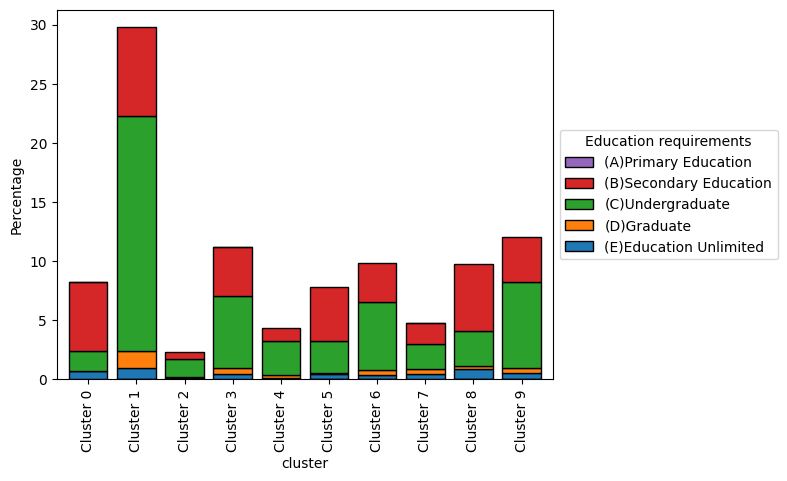

In [52]:
dfs = []

for x_id, x in enumerate(cluster_list):
    education_requirements = x.groupBy("Education requirements").count()
    education_requirements_pd = education_requirements.toPandas()
    education_requirements_pd['Cluster'] = x_id
    dfs.append(education_requirements_pd)


df = pd.concat(dfs)
df_pivot = df.pivot(index='Cluster', columns='Education requirements', values='count')
df_pivot = df_pivot.fillna(0)


df_pivot = df_pivot / df_pivot.sum().sum()
df_pivot = df_pivot * 100
df_pivot = df_pivot[df_pivot.columns[::-1]]
df_pivot.index = ['Cluster ' + str(i) for i in df_pivot.index]


ax = df_pivot.plot(kind='bar', stacked=True, edgecolor='black', width=0.8)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5), title='Education requirements')
plt.ylabel('Percentage')
plt.xlabel('cluster')
plt.show()

### Experience requirements analysis of jobs in each cluster [5 Marks]

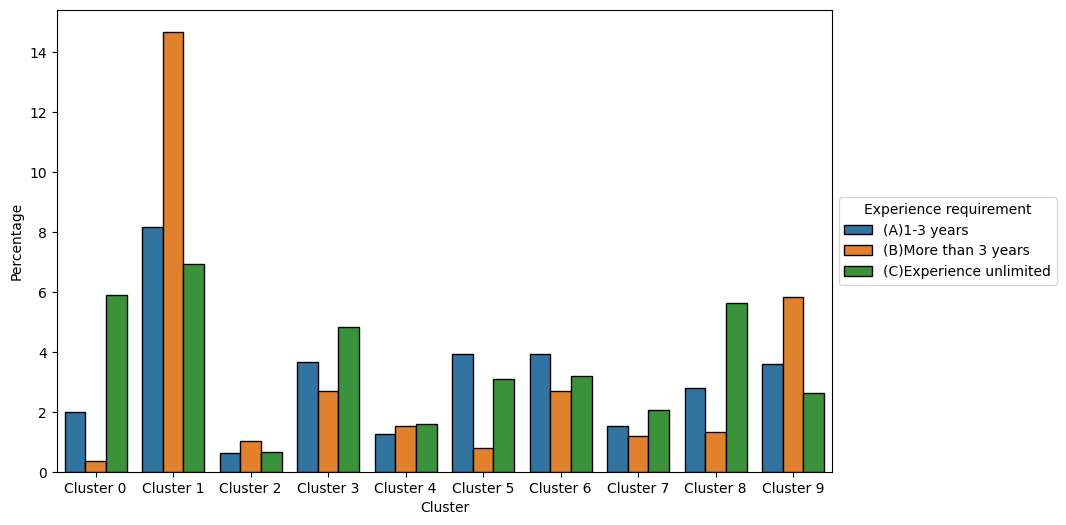

In [53]:
dfs = []

order = ["(A)1-3 years", "(B)More than 3 years", "(C)Experience unlimited"]

for x_id, x in enumerate(cluster_list):
    education_requirements = x.groupBy("Experience requirement").count()
    education_requirements_pd = education_requirements.toPandas()
    education_requirements_pd['Cluster'] = f'Cluster {x_id}'
    dfs.append(education_requirements_pd)


df = pd.concat(dfs)
total_count = df['count'].sum()
df['Percentage'] = df['count'] / total_count * 100
df['Experience requirement'] = pd.Categorical(df['Experience requirement'], order)

plt.figure(figsize=(10,6))
sns.barplot(data=df, x='Cluster', y='Percentage', hue='Experience requirement', edgecolor='black')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Experience requirement')
plt.ylabel('Percentage')
plt.xlabel('Cluster')
plt.show()

###Why do you think the majority of job adverts falling in Cluster 1 and Cluster 9 require `More than 3 years` experience? Provide your answer here. [10 Marks]


1. Looking at Cluster 9 and cluster one, the most frequent terms in these clusters are "manager", "management", "senior", "engineer". These are manageral positions which would require more experience. More complex or senior roles often require a certain level of expertise that can only be gained through experience. Industries and roles with steep learning curves may require applicants to have had time to learn, make mistakes, and develop their skills. Experience is a way of ensuring that an applicant has this expertise.

2. The salary in cluster 1 and cluster 9 is the higher than the averages of other clusters. This would suggest that these jobs require more experience as the salary is high.

### Salary range analysis of jobs in each cluster [5 Marks]

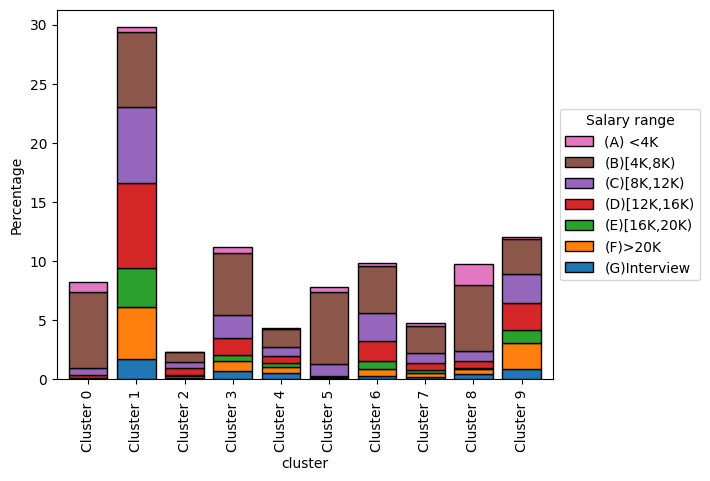

In [54]:
dfs = []

for x_id, x in enumerate(cluster_list):
    education_requirements = x.groupBy("Salary range").count()
    education_requirements_pd = education_requirements.toPandas()
    education_requirements_pd['Cluster'] = x_id
    dfs.append(education_requirements_pd)

df = pd.concat(dfs)


df_pivot = df.pivot(index='Cluster', columns='Salary range', values='count')
df_pivot = df_pivot.fillna(0) 

df_pivot = df_pivot / df_pivot.sum().sum()
df_pivot = df_pivot * 100
df_pivot = df_pivot[df_pivot.columns[::-1]]
df_pivot.index = ['Cluster ' + str(i) for i in df_pivot.index]


ax = df_pivot.plot(kind='bar', stacked=True, edgecolor='black', width=0.8)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5), title='Salary range')
plt.ylabel('Percentage')
plt.xlabel('cluster')
plt.show()
    

### Why do you think that jobs in Cluster 1 and Cluster 9 have a higher salary range compared to other clusters? Please provide your answer here. [10 Marks]

1. The "Salary range analysis of jobs according to city tier system" shows the higest earners stay in First Tier and First-New-Tier cities. This would mean Cluster 1 and Cluster 9 jobs reside in this city. It would also confirm why cluster 1 and cluster 9 have majority of the jobs as cities tend to offer more employement oppurtunies. 

2. Cluster 1 and Cluster 9 have more undergraduate and graduate education requirements compared to the rest of the clusters. Undergraduate and above level suggest high to advanced levels of technical work required which would have a higher salary. 

3. The percentage of jobs in cluster 1 and cluster 9 are high. The demand of jobs is very high. In this case there is a high demand of people in the field of data sciences which would make salaries competitive.

4. Looking at experience cluster 1 and cluster 9 need more experience for the job which suggest a higher salary

### Please critically evaluate the performance of the implementation of the K-means text clustering method in this notebook and provide suggestions for enhancing its performance. You are not required to implement your suggestions. Please provider your answer here. [10 Marks]



1. Confergence
The tolerence of the clustering is tol=0.000001, which is has a high tolerence. 50 iterations will also ensure that the data has reached convergence, meaning it is as close to the cluster point as possible. 

2. The use of cosine distance
The use of cosine distances would not have mattered if it or euclidean was used. There are six features, which is not consired a high number of dimension. Euclidean distance would have effetively worked in this instance

3. Silhoutte Coefficent and WSSS
Looking at which cluster was taken, 10, it was the lowest value in the WSSS vs cluster graph(Elbow graph). The max cluster size defined in the beginning was 10, however this had no reason for it other than bieng the max cluster size. The Silhoute Coefficent (measure of how similar an object is to its own cluster compaed to other clusters) which is a scale from -1 to 1 compared to the Silhoute distance in the K = 10 (0.238) indicated that clusters are not well separated from each other. A silhoutte coefficent near 0 suggests that the decision boundary between two neighboring clusters. I higher Silhoute Coefficient would ensure better clustered data. 

Drawing the elbow graph from 5-50 clusters would ensure a proper sized cluster as it would be taken at the elbow where more data would. Four cluster sizes were investigated using the "do clustering"

Running K-means using K = 15
- Silhouette coefficient computed with cosine distance: 0.295
- Within-cluster Sum of Squared Distances (using cosine distance): 5600.671

Running K-means using K = 25
- Silhouette coefficient computed with cosine distance: 0.374
- Within-cluster Sum of Squared Distances (using cosine distance): 4437.035

Running K-means using K = 35
- Silhouette coefficient computed with cosine distance: 0.413
- Within-cluster Sum of Squared Distances (using cosine distance): 3714.783

Running K-means using K = 45
- Silhouette coefficient computed with cosine distance: 0.447
- Within-cluster Sum of Squared Distances (using cosine distance): 288

This shows that 10 clusters is not the opitmal cluster size. Drawing the elbow graph would ensure correct cluster size selection



